In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Kidney
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Kidney data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Kidney')

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_kidney_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 4006.26it/s]
1833it [00:07, 257.56it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,method,mouse.id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.559082,6,2,EFO:0008931,...,NCBITaxon:10090,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.060743
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.011230,11,11,EFO:0008931,...,NCBITaxon:10090,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.125682
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,NCBITaxon:10090,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,male,kidney,na,18 month-old stage,0.228744
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,NCBITaxon:10090,kidney collecting duct epithelial cell,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,0.316740
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760254,0,4,EFO:0008931,...,NCBITaxon:10090,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.161026


## CMA net score/cell type (fold over whole tissue)

In [6]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_46_F', '18_47_F', '18_53_M', '18_45_M', '24_59_M', '24_58_M', '24_60_M', '24_61_M', '3_38_F', '3_39_F', '3_10_M', '3_11_M', '3_9_M', '3_8_M']


**Mice n for Liver**
    - Young females: 2
    - Young males: 4
    - Old females: 2
    - Old males: 6

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    else:                
        barcode.loc[j, 'new_age'] = '18-24m'

barcode.head()

,FACS.selection,age,cell,method,mouse.id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.559082,6,2,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.060743,18-24m
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.011230,11,11,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.125682,18-24m
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,male,kidney,na,18 month-old stage,0.228744,18-24m
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,kidney collecting duct epithelial cell,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,0.316740,18-24m
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760254,0,4,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.161026,18-24m


In [8]:
print(list(barcode.cell_type.unique()))

['epithelial cell of proximal tubule', 'kidney collecting duct epithelial cell', 'kidney loop of Henle ascending limb epithelial cell', 'macrophage', 'T cell', 'fenestrated cell', 'kidney collecting duct principal cell', 'B cell', 'mesangial cell', 'kidney interstitial fibroblast']


In [9]:
# Generating new cell types
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'epithelial cell of proximal tubule':        
        barcode.loc[j, 'new_cell'] = 'proximal tubule epithelial cell'
    
    elif barcode.loc[j, 'cell_type'] == 'kidney collecting duct epithelial cell' or barcode.loc[j, 'cell_type'] == 'kidney collecting duct principal cell':        
        barcode.loc[j, 'new_cell'] = 'collecting duct epithelial cell'

    else:                
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']
        

100%|████████████████████████████████████████████████████████████████████████████| 1833/1833 [00:00<00:00, 5213.62it/s]


In [10]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,method,mouse.id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.559082,6,2,EFO:0008931,...,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.060743,18-24m,proximal tubule epithelial cell,-0.067226
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.011230,11,11,EFO:0008931,...,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.125682,18-24m,proximal tubule epithelial cell,-0.132165
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,normal,Mus musculus,male,kidney,na,18 month-old stage,0.228744,18-24m,proximal tubule epithelial cell,0.222261
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,normal,Mus musculus,female,kidney,na,18 month-old stage,0.316740,18-24m,collecting duct epithelial cell,0.310257
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760254,0,4,EFO:0008931,...,normal,Mus musculus,female,kidney,na,18 month-old stage,-0.161026,18-24m,proximal tubule epithelial cell,-0.167509


In [11]:
cells = ['fenestrated cell', 'mesangial cell', 'proximal tubule epithelial cell', 'collecting duct epithelial cell']

### Cell types stats

In [12]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [13]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,fenestrated cell,3m,113,0.488241,0.783393,Normal
1,fenestrated cell,18-24m,155,2.377878,0.304544,Normal
2,mesangial cell,3m,32,23.853401,0.000007,Not normal
3,mesangial cell,18-24m,61,2.446125,0.294327,Normal
4,proximal tubule epithelial cell,3m,46,0.003021,0.998490,Normal
5,proximal tubule epithelial cell,18-24m,347,9.530474,0.008521,Not normal
6,collecting duct epithelial cell,3m,179,1.682750,0.431117,Normal
7,collecting duct epithelial cell,18-24m,423,3.771075,0.151747,Normal


In [15]:
# T test for normal populations
for i in ['fenestrated cell', 'collecting duct epithelial cell']:
    # Levene
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} stats'.format(i.title()))
    print("Length 3m: " + str(len(group3)))
    print("Length 18-24m: " + str(len(group18_24)))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval = " + str(p))

    # T test
    stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
    print("T test pval = " + str(p2))
    print('\n')

Fenestrated Cell stats
Length 3m: 113
Length 18-24m: 155
Levene's test pval = 0.9536053521076372
T test pval = 0.91152452779934


Length 3m: 179
Length 18-24m: 423
Levene's test pval = 0.3106161288469518
T test pval = 0.7738191418300213




C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\471175832.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\471175832.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


In [16]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in ['mesangial cell', 'proximal tubule epithelial cell']:
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Mesangial Cell statistics
MWU test pval = 0.712904591654894


Proximal Tubule Epithelial Cell statistics
MWU test pval = 0.99834678297644




C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\4265173804.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\4265173804.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

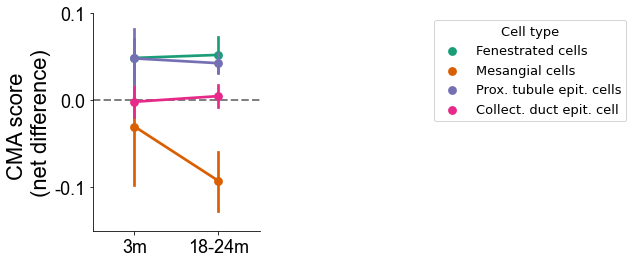

In [19]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='new_cell', order=["3m", "18-24m"], 
              hue_order=cells, palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.15, 0.10) 
ax.set_yticks([-0.10, 0.00, 0.10])
ax.set_yticklabels([-0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})

# Legend
celulas = ['Fenestrated cells', 'Mesangial cells', 'Prox. tubule epit. cells', 'Collect. duct epit. cell']
h, l = ax.get_legend_handles_labels()
ax.legend(h, celulas, bbox_to_anchor=(2, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

plt.savefig('../Khwaja_et_al_outputs/Kidney/Kidney_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [20]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\1532967860.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\1532967860.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\1532967860.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,fenestrated cell,3m,113,0.048753,0.023807
1,fenestrated cell,18-24m,155,0.052252,0.020504
2,mesangial cell,3m,32,-0.030118,0.070123
3,mesangial cell,18-24m,61,-0.092410,0.032908
4,proximal tubule epithelial cell,3m,46,0.048209,0.031658
5,proximal tubule epithelial cell,18-24m,347,0.042722,0.012111
6,collecting duct epithelial cell,3m,179,-0.001640,0.017971
7,collecting duct epithelial cell,18-24m,423,0.004821,0.012485


In [21]:
df_raw.to_excel('../Khwaja_et_al_outputs/Kidney/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [22]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(barcode[barcode["new_cell"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Fenestrated Cell length:268
sex     new_age
male    18-24m     125
female  3m          57
male    3m          56
female  18-24m      30
dtype: int64


Mesangial Cell length:93
sex     new_age
female  18-24m     35
male    18-24m     26
        3m         18
female  3m         14
dtype: int64


Proximal Tubule Epithelial Cell length:393
sex     new_age
male    18-24m     262
female  18-24m      85
male    3m          43
female  3m           3
dtype: int64


sex     new_age
female  18-24m     243
male    18-24m     180
        3m         110
female  3m          69
dtype: int64




In [23]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['new_cell']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Fenestrated Cell 2-way Anova

                      df     sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0   0.000800  0.000800  0.012541  0.910921
C(sex)               1.0   0.250758  0.250758  3.929454  0.048484
C(new_age):C(sex)    1.0   0.110658  0.110658  1.734043  0.189037
Residual           264.0  16.847138  0.063815       NaN       NaN


Fenestrated Cell Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -0.3749 0.7082       1.0  False
18-24m & female   3m & female  0.7661 0.4458       1.0  False
18-24m & female     3m & male  -1.212 0.2289       1.0  False
  18-24m & male   3m & female  1.5435 0.1245    0.7468  False
  18-24m & male     3m & male -1.2003 0.2316       1.0  False
    3m & female     3m & male -2.3941 0.0183      0.11  False
-----------

### Graphs

#### Fenestrated cell

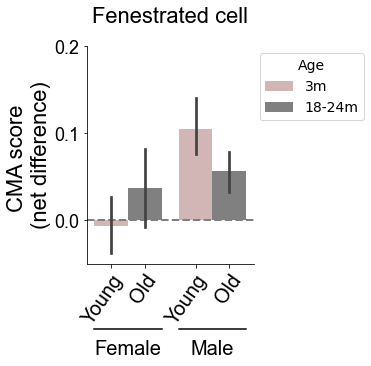

In [28]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='fenestrated cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.05, 0.20)
ax.set_yticks([0.0, 0.10, 0.20])
ax.set_yticklabels([0.0, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Fenestrated cell', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Fen_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Mesangial cell

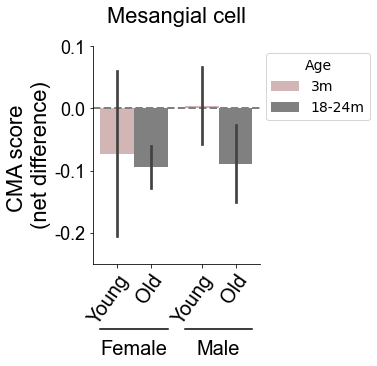

In [32]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='mesangial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.10)
ax.set_yticks([-0.20, -0.10, 0.0, 0.10])
ax.set_yticklabels([-0.20, -0.10, 0.0, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Mesangial cell', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Mes_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Proximal tubule epithelial cell

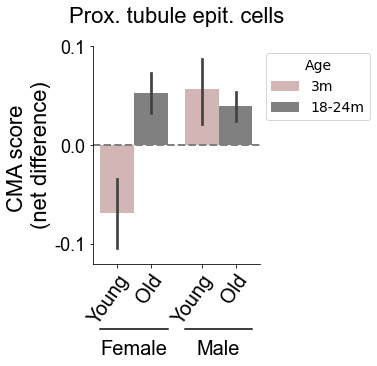

In [37]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='proximal tubule epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.10)
ax.set_yticks([-0.10, 0.0, 0.10])
ax.set_yticklabels([-0.10, 0.0, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Prox. tubule epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Prox_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Collecting duct epithelial cell

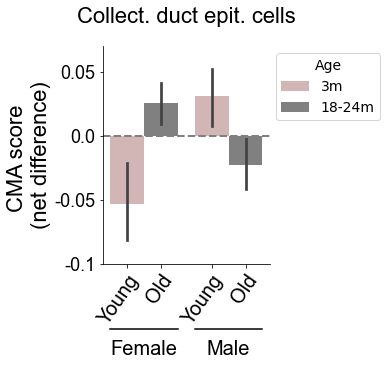

In [41]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell=='collecting duct epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.07)
ax.set_yticks([-0.10, -0.05, 0.0, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.0, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Collect. duct epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Col_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [42]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Kidney/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [43]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\365507413.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\365507413.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\365507413.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,fenestrated cell,3m,female,57,-0.006584,0.032775
1,fenestrated cell,3m,male,56,0.105078,0.033186
2,fenestrated cell,18-24m,female,30,0.036515,0.046229
3,fenestrated cell,18-24m,male,125,0.056029,0.022954
4,mesangial cell,3m,female,14,-0.073324,0.140244
5,mesangial cell,3m,male,18,0.003487,0.063958
6,mesangial cell,18-24m,female,35,-0.094472,0.033363
7,mesangial cell,18-24m,male,26,-0.089633,0.063713
8,proximal tubule epithelial cell,3m,female,3,-0.068850,0.039179
9,proximal tubule epithelial cell,3m,male,43,0.056376,0.033456


## CMA net score/cell type & sex (fold over each cell type young)

In [44]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\355703340.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 2681.92it/s]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\355703340.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|██████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 7358.17it/s]


,FACS.selection,age,cell,method,mouse.id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.559082,6,2,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,-0.060743,18-24m,proximal tubule epithelial cell,-0.067226,-0.115435
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.011230,11,11,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,-0.125682,18-24m,proximal tubule epithelial cell,-0.132165,-0.180374
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,Mus musculus,male,kidney,na,18 month-old stage,0.228744,18-24m,proximal tubule epithelial cell,0.222261,0.174052
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,0.316740,18-24m,collecting duct epithelial cell,0.310257,0.311897
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760254,0,4,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,-0.161026,18-24m,proximal tubule epithelial cell,-0.167509,-0.215718


### Graphs

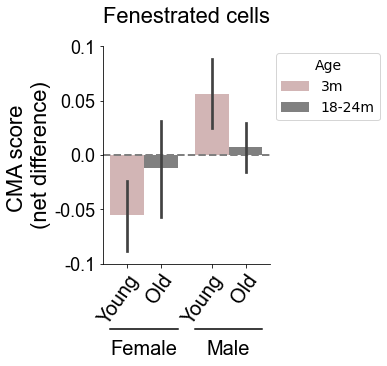

In [46]:
# Figure Fenestrated cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='fenestrated cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Fenestrated cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig('../Khwaja_et_al_outputs/Kidney/Fen_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

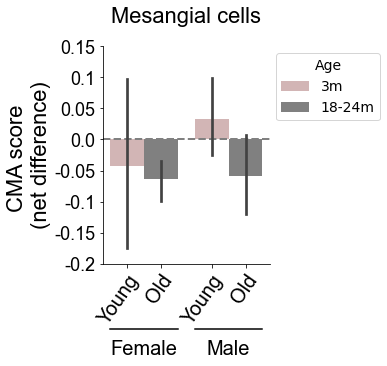

In [47]:
# Figure Mesangial cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='mesangial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.15)
ax.set_yticks([-.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
ax.set_yticklabels([-.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Mesangial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Mes_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

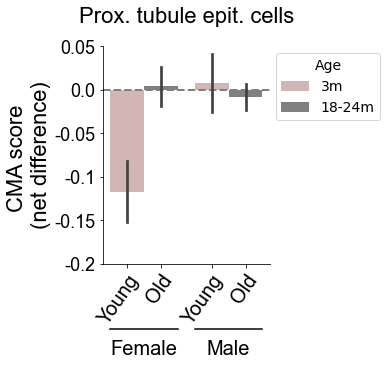

In [48]:
# Figure Prox. tub. epit. cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='proximal tubule epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.05)
ax.set_yticks([-0.20, -0.15, -0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.20, -0.15, -0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Prox. tubule epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Prox_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

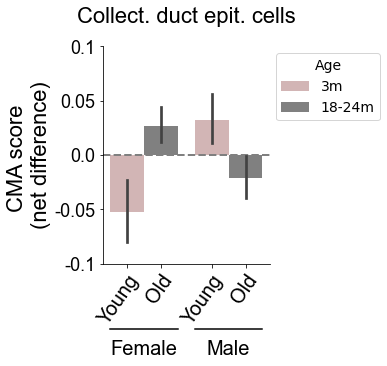

In [50]:
# Figure Collecting duct epit. cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='collecting duct epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Collect. duct epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Col_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [51]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Kidney/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [52]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\3584696876.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\3584696876.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\3584696876.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,fenestrated cell,3m,female,57,-0.055337,0.032775
1,fenestrated cell,3m,male,56,0.056325,0.033186
2,fenestrated cell,18-24m,female,30,-0.012238,0.046229
3,fenestrated cell,18-24m,male,125,0.007276,0.022954
4,mesangial cell,3m,female,14,-0.043206,0.140244
5,mesangial cell,3m,male,18,0.033605,0.063958
6,mesangial cell,18-24m,female,35,-0.064354,0.033363
7,mesangial cell,18-24m,male,26,-0.059515,0.063713
8,proximal tubule epithelial cell,3m,female,3,-0.117059,0.039179
9,proximal tubule epithelial cell,3m,male,43,0.008167,0.033456


## CMA network heatmaps by cell type & sex

In [53]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [60]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Kidney/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap including all conditions
    if cellpop == 'mesangial cell':
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
                
    else:
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)            
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    
    plt.savefig('../Khwaja_et_al_outputs/Kidney/{}_heat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellp

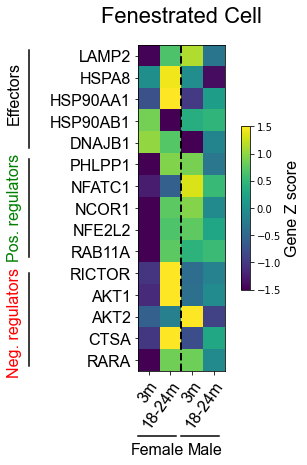

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellp

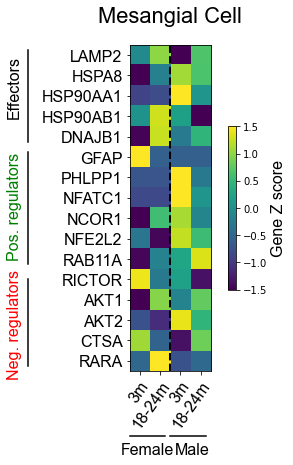

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellp

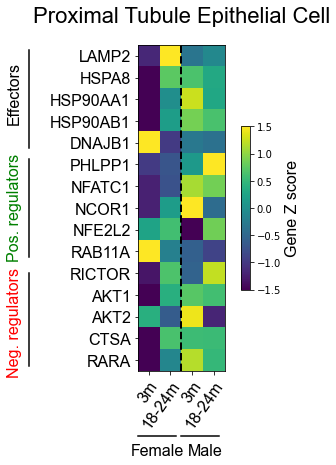

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\849817792.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellp

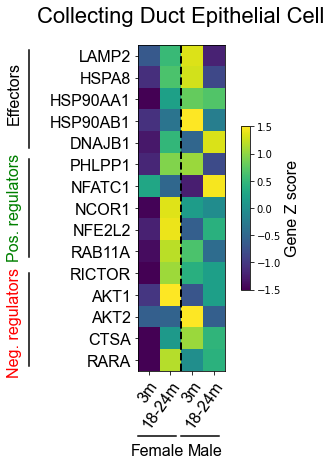

In [61]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [62]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [63]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 332.92it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A12_B002350_B009947_S12.mm10-plus-4-0,A12_B002350,epithelial cell of proximal tubule,female,18m,1.176406,0.852423
1,A12_B002352_B009948_S12.mm10-plus-4-0,A12_B002352,epithelial cell of proximal tubule,female,18m,0.888209,0.694633
2,A13_B002697_B009938_S13.mm10-plus-4-0,A13_B002697,epithelial cell of proximal tubule,male,18m,1.171615,0.805614
3,A15_B002352_B009948_S15.mm10-plus-4-0,A15_B002352,kidney collecting duct epithelial cell,female,18m,0.751585,0.460106
4,A16_B002352_B009948_S16.mm10-plus-4-0,A16_B002352,epithelial cell of proximal tubule,female,18m,0.962812,0.653478


In [64]:
cells 

['fenestrated cell',
 'mesangial cell',
 'proximal tubule epithelial cell',
 'collecting duct epithelial cell']

In [65]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    else:                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

# Generating new cell types combining some of them
for j in tqdm(barcode_lys.index):    
    if barcode_lys.loc[j, 'cell_type'] == 'epithelial cell of proximal tubule':        
        barcode_lys.loc[j, 'new_cell'] = 'proximal tubule epithelial cell'
    
    elif barcode_lys.loc[j, 'cell_type'] == 'kidney collecting duct epithelial cell' or barcode_lys.loc[j, 'cell_type'] == 'kidney collecting duct principal cell':        
        barcode_lys.loc[j, 'new_cell'] = 'collecting duct epithelial cell'

    else:                
        barcode_lys.loc[j, 'new_cell'] = barcode_lys.loc[j, 'cell_type']
     
barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████| 1833/1833 [00:00<00:00, 5411.17it/s]


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A12_B002350_B009947_S12.mm10-plus-4-0,A12_B002350,epithelial cell of proximal tubule,female,18m,1.176406,0.852423,18-24m,proximal tubule epithelial cell
1,A12_B002352_B009948_S12.mm10-plus-4-0,A12_B002352,epithelial cell of proximal tubule,female,18m,0.888209,0.694633,18-24m,proximal tubule epithelial cell
2,A13_B002697_B009938_S13.mm10-plus-4-0,A13_B002697,epithelial cell of proximal tubule,male,18m,1.171615,0.805614,18-24m,proximal tubule epithelial cell
3,A15_B002352_B009948_S15.mm10-plus-4-0,A15_B002352,kidney collecting duct epithelial cell,female,18m,0.751585,0.460106,18-24m,collecting duct epithelial cell
4,A16_B002352_B009948_S16.mm10-plus-4-0,A16_B002352,epithelial cell of proximal tubule,female,18m,0.962812,0.653478,18-24m,proximal tubule epithelial cell


In [66]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[barcode_lys['new_cell'].isin(cells)]
print(barcode_lys.new_cell.unique())
barcode_lys.head()

['proximal tubule epithelial cell' 'collecting duct epithelial cell'
 'fenestrated cell' 'mesangial cell']


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A12_B002350_B009947_S12.mm10-plus-4-0,A12_B002350,epithelial cell of proximal tubule,female,18m,1.176406,0.852423,18-24m,proximal tubule epithelial cell
1,A12_B002352_B009948_S12.mm10-plus-4-0,A12_B002352,epithelial cell of proximal tubule,female,18m,0.888209,0.694633,18-24m,proximal tubule epithelial cell
2,A13_B002697_B009938_S13.mm10-plus-4-0,A13_B002697,epithelial cell of proximal tubule,male,18m,1.171615,0.805614,18-24m,proximal tubule epithelial cell
3,A15_B002352_B009948_S15.mm10-plus-4-0,A15_B002352,kidney collecting duct epithelial cell,female,18m,0.751585,0.460106,18-24m,collecting duct epithelial cell
4,A16_B002352_B009948_S16.mm10-plus-4-0,A16_B002352,epithelial cell of proximal tubule,female,18m,0.962812,0.653478,18-24m,proximal tubule epithelial cell


### Graphs

#### Lamp2 female

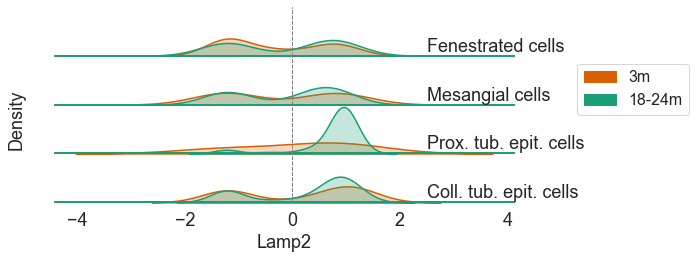

In [72]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=4.1, s='Fenestrated cells', fontsize=18) 
plt.text(x=2.5, y=2.75, s='Mesangial cells', fontsize=18)
plt.text(x=2.5, y=1.45, s='Prox. tub. epit. cells'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.12, s='Coll. tub. epit. cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Kidney/KidL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

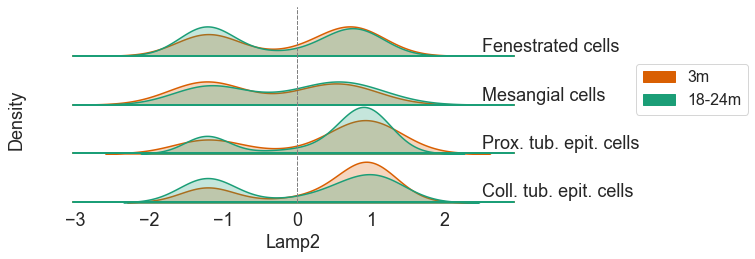

In [87]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=2.55, s='Fenestrated cells', fontsize=18) 
plt.text(x=2.5, y=1.72, s='Mesangial cells', fontsize=18)
plt.text(x=2.5, y=0.91, s='Prox. tub. epit. cells'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.1, s='Coll. tub. epit. cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.55, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Kidney/KidL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

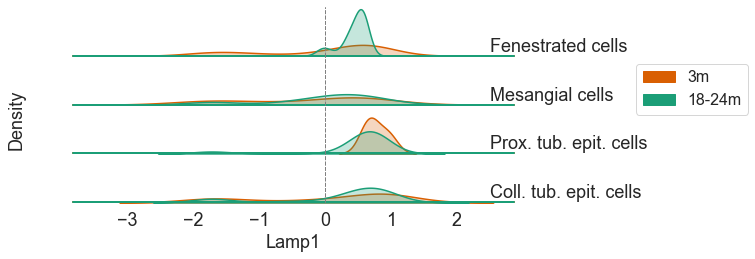

In [105]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=8.15, s='Fenestrated cells', fontsize=18) 
plt.text(x=2.5, y=5.5, s='Mesangial cells', fontsize=18)
plt.text(x=2.5, y=2.9, s='Prox. tub. epit. cells'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.25, s='Coll. tub. epit. cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.55, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Kidney/KidL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

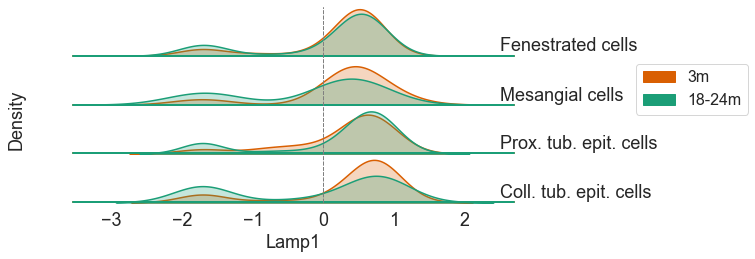

In [117]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.5, y=3, s='Fenestrated cells', fontsize=18) 
plt.text(x=2.5, y=2, s='Mesangial cells', fontsize=18)
plt.text(x=2.5, y=1.05, s='Prox. tub. epit. cells'.capitalize(), fontsize=18)
plt.text(x=2.5, y=0.1, s='Coll. tub. epit. cells', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.55, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Kidney/KidL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [118]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['new_cell']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Fenestrated Cell 2-way Anova

                      df      sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0    0.000896  0.000896  0.000987  0.974966
C(sex)               1.0    0.465146  0.465146  0.512089  0.474868
C(new_age):C(sex)    1.0    1.652552  1.652552  1.819331  0.178549
Residual           264.0  239.799047  0.908330       NaN       NaN


Fenestrated Cell Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  0.4953 0.6211       1.0  False
18-24m & female   3m & female  0.9923 0.3239       1.0  False
18-24m & female     3m & male -0.2215 0.8252       1.0  False
  18-24m & male   3m & female  0.7423 0.4588       1.0  False
  18-24m & male     3m & male -0.9441 0.3464       1.0  False
    3m & female     3m & male -1.4775 0.1424    0.8542  False
------

### Graphs

In [119]:
sns.reset_defaults()

#### Fenestrated cells

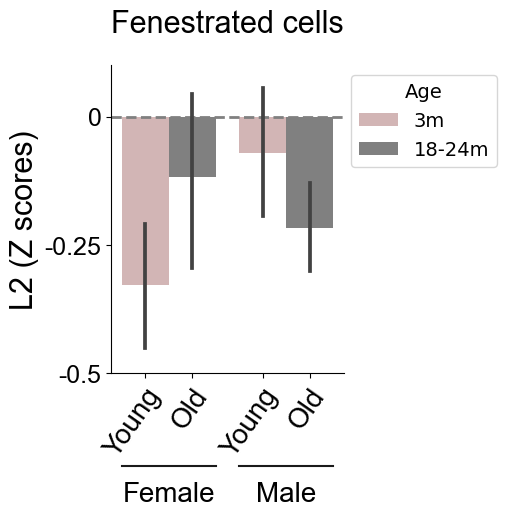

In [122]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='fenestrated cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.5, 0.10)
ax.set_yticks([-0.5, -0.25, 0])
ax.set_yticklabels([-0.5, -0.25, 0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Fenestrated cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Fen_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Mesangial cells

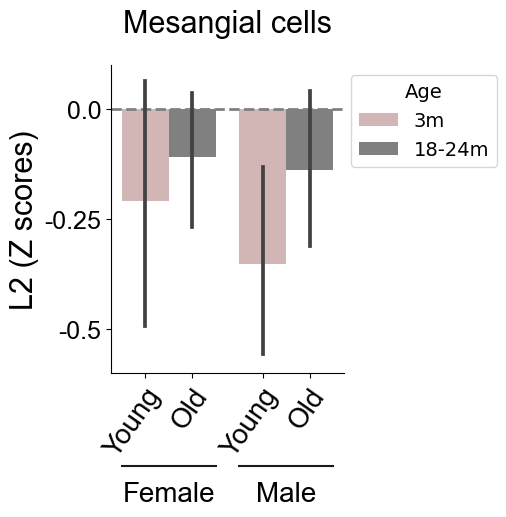

In [127]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='mesangial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.6, 0.10)
ax.set_yticks([-0.5, -0.25, 0.0])
ax.set_yticklabels([-0.5, -0.25, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Mesangial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Mes_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Proximal tubule epithelial cells

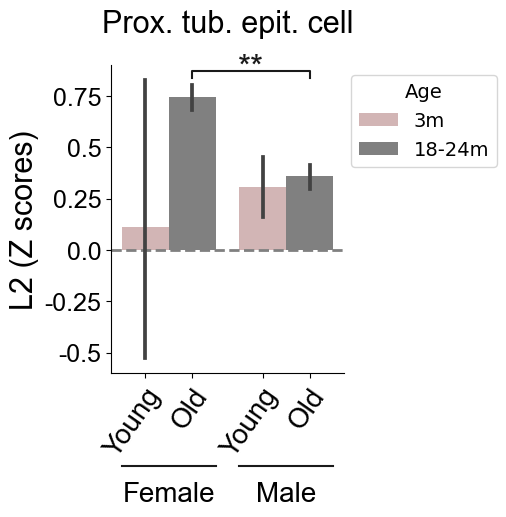

In [138]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='proximal tubule epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.6, 0.90)
ax.set_yticks([-0.50, -0.25, 0.0, 0.25, 0.50, 0.75])
ax.set_yticklabels([-0.50, -0.25, 0.0, 0.25, 0.50, 0.75], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Prox. tub. epit. cell', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.2, 1.2   
y, h, col = 0.84, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.03, "**", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Prox_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Collecting duct epithelial cells

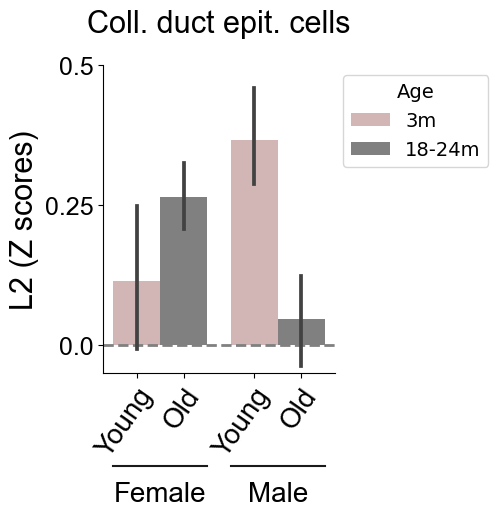

In [146]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell=='collecting duct epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.05, 0.5)
ax.set_yticks([0.0, 0.25, 0.50])
ax.set_yticklabels([0.0, 0.25, 0.50], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Coll. duct epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Kidney/Col_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [147]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Kidney/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [148]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\3611662640.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\3611662640.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_12704\3611662640.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,fenestrated cell,3m,female,57,-0.329083,0.121556
1,fenestrated cell,3m,male,56,-0.070618,0.125855
2,fenestrated cell,18-24m,female,30,-0.118553,0.179520
3,fenestrated cell,18-24m,male,125,-0.216188,0.086439
4,mesangial cell,3m,female,14,-0.208966,0.282918
5,mesangial cell,3m,male,18,-0.352947,0.214934
6,mesangial cell,18-24m,female,35,-0.108493,0.154133
7,mesangial cell,18-24m,male,26,-0.138881,0.178699
8,proximal tubule epithelial cell,3m,female,3,0.114387,0.674069
9,proximal tubule epithelial cell,3m,male,43,0.304791,0.147599
